# Lab 5: Alternative Finance & Credit Risk Scoring

Marketplace lending economics and credit prediction

> **Expected Time**
>
> -   FIN510: Seminar hands‑on ≈ 60 min
> -   Directed learning extensions ≈ 90–120 min
> -   FIN720: Computer lab ≈ 120 min

<figure>
<a
href="https://colab.research.google.com/github/quinfer/fin510-colab-notebooks/blob/main/labs/lab05_alt_finance.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open in Colab</figcaption>
</figure>

## Setup (Colab‑only installs)

In [1]:
try:
    import pandas
    import numpy
    import matplotlib
    import sklearn
except Exception:
    !pip -q install pandas numpy matplotlib scikit-learn

## Before You Code: The Big Picture

Traditional banks reject 45 million Americans with “thin credit
files”—no credit history means no loan, even if they’re good risks.
Alternative finance platforms (LendingClub, Prosper, Funding Circle) use
**alternative data**: education, employment history, cash flow patterns.
This expands access—but does it work?

> **The Alternative Data Promise**
>
> **The Problem:**  
> Credit scores (FICO) are incomplete. Many creditworthy people have no
> score because they’ve never borrowed. Traditional banks reject them
> automatically.
>
> **The Solution (Alternative Data):**  
> - Education history (college degree = lower default risk) - Employment
> stability (years at job = reliability signal) - Cash flow patterns
> (consistent income = repayment capacity) - Digital footprint (social
> media, app usage)
>
> **The Evidence:**  
> Berg et al. (2020, RFS) show alternative data reduces prediction error
> by 15-25% for thin-file borrowers. This could expand credit access to
> 20M+ Americans.
>
> **The Tradeoffs:**  
> - ✅ Financial inclusion: More people get loans - ⚠️ Privacy: More
> data collection - ⚠️ Fairness: Could alternative data embed bias?

### What You’ll Build Today

By the end of this lab, you will have:

-   ✅ Credit default prediction model (logistic regression)
-   ✅ Comparison: traditional features vs. alternative data
-   ✅ Performance metrics (AUC, precision, recall)
-   ✅ Economic analysis of investor returns across risk grades
-   ✅ Framework for evaluating inclusion-fairness tradeoffs

**Time estimate:** 60 minutes (FIN510) \| 90-120 minutes (FIN720 with
extensions)

> **Why This Matters**
>
> In Coursework 2 (FIN720), you might evaluate marketplace lending or
> BNPL (Buy-Now-Pay-Later). This lab gives you the tools: how do you
> measure credit risk? What’s the investor value proposition? What are
> the fairness implications?

## Objectives

By the end of this lab, you will be able to:

-   Implement logistic regression for credit default prediction
-   Compare traditional credit features vs. adding alternative data
-   Evaluate model performance using AUC, precision, and recall
-   Analyze marketplace lending economics (risk-return tradeoffs)
-   Calculate investor returns across different loan grades
-   Reflect on inclusion benefits and fairness tradeoffs

## Session Flow (≈ 60 minutes)

> **Suggested Timing**
>
> -   Setup and data exploration (10 minutes)
> -   Task 1: Baseline credit scoring model (15 minutes)
> -   Task 2: Alternative data enhancement (15 minutes)
> -   Task 3: Marketplace lending economics (15 minutes)
> -   Interpretation and reflection (5 minutes)

This plan moves from credit risk modeling to economic analysis to policy
implications.

## Understanding Credit Risk in Marketplace Lending

Before we code, let’s understand the problem. Marketplace lending
platforms must predict which borrowers will default (fail to repay).
Traditional banks use credit scores (FICO), but these exclude 45M
Americans with “thin files” (no credit history).

Alternative data—education, employment stability, cash flow patterns—can
improve predictions, especially for thin-file borrowers. This week’s lab
implements this idea, demonstrating Berg et al. (2020)’s findings that
alternative data reduces prediction error by 15-25%.

We’ll also analyze the economics: how do investor returns vary across
risk grades? Is the risk-return tradeoff fair?

## Task 1 — Baseline Credit Scoring Model

Let’s start with a traditional credit scoring approach using only
standard features, then measure performance.

Dataset Overview:
Total loans: 5,000
Default rate: 57.4%

Feature ranges:
       credit_score  annual_income  debt_to_income   loan_amount
count   5000.000000    5000.000000     5000.000000   5000.000000
mean     679.967719   58383.364229        0.297880  15097.000000
std       78.504152   36251.652067        0.194369   7070.755979
min      420.698613   20000.000000        0.002032   5000.000000
25%      627.367597   32469.298512        0.147675  10000.000000
50%      681.077247   48510.217270        0.253192  15000.000000
75%      733.280849   73595.773044        0.407986  20000.000000
max      850.000000  200000.000000        0.800000  25000.000000

✅ Traditional Model Performance:
   AUC-ROC: 0.577

Classification Report:
              precision    recall  f1-score   support

      Repaid       0.58      0.10      0.18       640
   Defaulted       0.59      0.94      0.72       860

    accuracy                           0.59      1500
   macro avg       0.58      0.52      0.45    

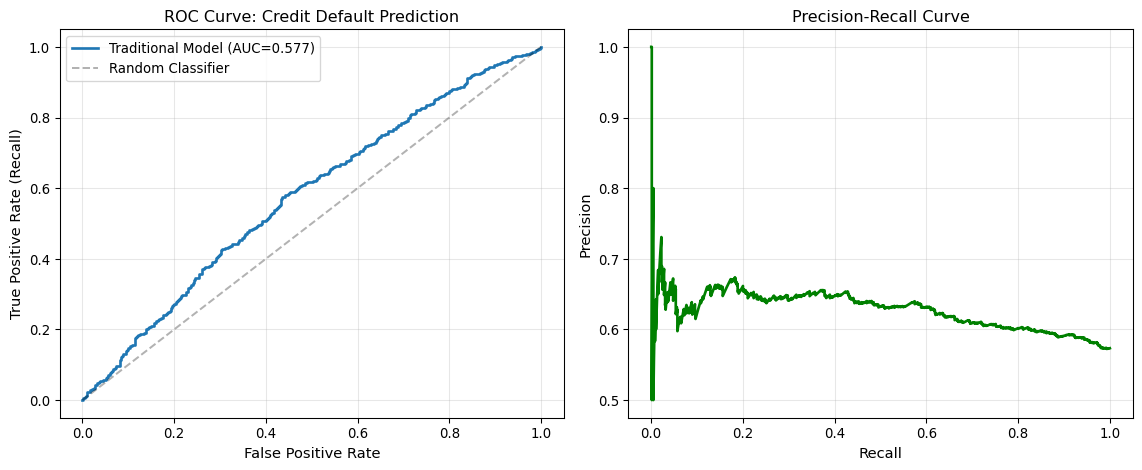


✔ Traditional credit scoring model complete

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report

# Create synthetic marketplace lending dataset
# (In practice, you'd use real data from LendingClub, Prosper, or Funding Circle)
np.random.seed(42)
n_samples = 5000

# Generate features
data = pd.DataFrame({
    # Traditional features
    'credit_score': np.random.normal(680, 80, n_samples).clip(300, 850),
    'annual_income': np.random.lognormal(10.8, 0.6, n_samples).clip(20000, 200000),
    'debt_to_income': np.random.gamma(2, 0.15, n_samples).clip(0, 0.8),
    'loan_amount': np.random.choice([5000, 10000, 15000, 20000, 25000], n_samples),
    
    # Alternative data features (we'll use these in Task 2)
    'has_college_degree': np.random.binomial(1, 0.35, n_samples),
    'employment_years': np.random.exponential(3, n_samples).clip(0, 20),
    'monthly_cashflow': np.random.normal(500, 800, n_samples),
})

# Generate default outcome (probability depends on features)
default_prob = (
    0.30  # baseline
    - 0.0015 * (data['credit_score'] - 680)  # credit score effect
    - 0.000005 * (data['annual_income'] - 55000)  # income effect
    + 0.40 * data['debt_to_income']  # debt ratio effect
    + 0.00001 * (data['loan_amount'] - 15000)  # loan size effect
    # Alternative data effects (in reality, but we won't use these in baseline)
    - 0.08 * data['has_college_degree']
    - 0.008 * data['employment_years']
    - 0.0001 * data['monthly_cashflow']
)

# Add noise and convert to binary outcome
default_prob = 1 / (1 + np.exp(-default_prob))  # logistic transform
data['defaulted'] = (np.random.random(n_samples) < default_prob).astype(int)

# Show basic statistics
print("Dataset Overview:")
print("=" * 60)
print(f"Total loans: {len(data):,}")
print(f"Default rate: {data['defaulted'].mean():.1%}")
print(f"\nFeature ranges:")
print(data[['credit_score', 'annual_income', 'debt_to_income', 'loan_amount']].describe())

# Traditional model: use only credit score, income, DTI, loan amount
X_traditional = data[['credit_score', 'annual_income', 'debt_to_income', 'loan_amount']]
y = data['defaulted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_traditional, y, test_size=0.3, random_state=42, stratify=y
)

# Train logistic regression
lr_traditional = LogisticRegression(random_state=42, max_iter=1000)
lr_traditional.fit(X_train, y_train)

# Predictions
y_pred_proba = lr_traditional.predict_proba(X_test)[:, 1]
y_pred = lr_traditional.predict(X_test)

# Evaluate
auc_traditional = roc_auc_score(y_test, y_pred_proba)

print(f"\n✅ Traditional Model Performance:")
print(f"   AUC-ROC: {auc_traditional:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Repaid', 'Defaulted']))

# Visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(12, 5))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, linewidth=2, label=f'Traditional Model (AUC={auc_traditional:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate (Recall)', fontsize=11)
plt.title('ROC Curve: Credit Default Prediction', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, linewidth=2, color='green')
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Precision-Recall Curve', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✔ Traditional credit scoring model complete")

### Interpretation Guide

1.  **AUC interpretation**: An AUC of ~0.70 is typical for traditional
    credit models. What does this mean? (70% of the time, the model
    ranks a random defaulter as higher risk than a random
    non-defaulter.)

2.  **Precision vs. Recall tradeoff**: Look at the classification
    report. Which matters more—catching all defaults (high recall) or
    avoiding false alarms (high precision)? For a lending platform,
    what’s the cost of each error type?

3.  **Feature importance**: Which traditional feature is most
    predictive? (Check model coefficients.) Does this match your
    intuition?

Write 150–200 words interpreting the baseline model’s performance and
discussing its limitations for thin-file borrowers.

## Task 2 — Enhancing with Alternative Data

Now let’s add alternative data features and measure the improvement.
This demonstrates Berg et al. (2020)’s finding that alternative data
reduces prediction error.

✅ Alternative Data Model Performance:
   AUC-ROC: 0.578
   Improvement: +0.002 (0.3%)

Classification Report:
              precision    recall  f1-score   support

      Repaid       0.58      0.14      0.22       640
   Defaulted       0.59      0.93      0.72       860

    accuracy                           0.59      1500
   macro avg       0.58      0.53      0.47      1500
weighted avg       0.59      0.59      0.51      1500


Feature Importance (by absolute coefficient):
  debt_to_income              0.2614
  has_college_degree         -0.1985
  employment_years           -0.0066
  credit_score               -0.0013
  monthly_cashflow           -0.0001
  loan_amount                 0.0000
  annual_income              -0.0000

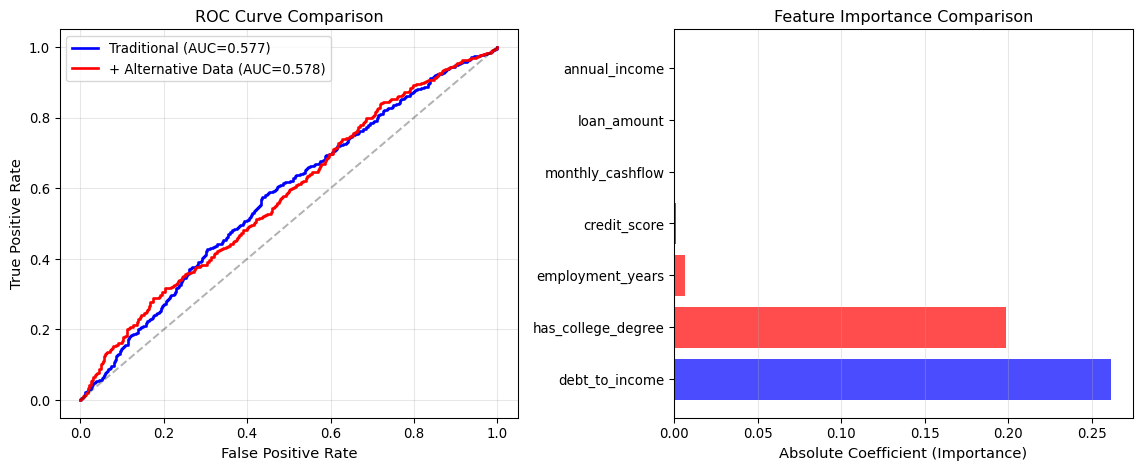


✔ Alternative data model complete

In [3]:
# Alternative data model: add education, employment, cashflow
X_alternative = data[['credit_score', 'annual_income', 'debt_to_income', 'loan_amount',
                       'has_college_degree', 'employment_years', 'monthly_cashflow']]

# Train-test split
X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(
    X_alternative, y, test_size=0.3, random_state=42, stratify=y
)

# Train enhanced model
lr_alternative = LogisticRegression(random_state=42, max_iter=1000)
lr_alternative.fit(X_train_alt, y_train_alt)

# Predictions
y_pred_proba_alt = lr_alternative.predict_proba(X_test_alt)[:, 1]
y_pred_alt = lr_alternative.predict(X_test_alt)

# Evaluate
auc_alternative = roc_auc_score(y_test_alt, y_pred_proba_alt)

print("✅ Alternative Data Model Performance:")
print(f"   AUC-ROC: {auc_alternative:.3f}")
print(f"   Improvement: +{(auc_alternative - auc_traditional):.3f} ({(auc_alternative/auc_traditional - 1)*100:.1f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test_alt, y_pred_alt, target_names=['Repaid', 'Defaulted']))

# Feature importance analysis
feature_names = X_alternative.columns
coefficients = lr_alternative.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance (by absolute coefficient):")
print("=" * 60)
for _, row in feature_importance.iterrows():
    print(f"  {row['Feature']:<25} {row['Coefficient']:>8.4f}")

# Compare ROC curves
fpr_alt, tpr_alt, _ = roc_curve(y_test_alt, y_pred_proba_alt)

plt.figure(figsize=(12, 5))

# Panel 1: ROC comparison
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, linewidth=2, label=f'Traditional (AUC={auc_traditional:.3f})', color='blue')
plt.plot(fpr_alt, tpr_alt, linewidth=2, label=f'+ Alternative Data (AUC={auc_alternative:.3f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve Comparison', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Panel 2: Feature importance
plt.subplot(1, 2, 2)
colors = ['red' if 'college' in feat or 'employment' in feat or 'cashflow' in feat else 'blue' 
          for feat in feature_importance['Feature']]
plt.barh(range(len(feature_importance)), feature_importance['Abs_Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Absolute Coefficient (Importance)', fontsize=11)
plt.title('Feature Importance Comparison', fontsize=12)
plt.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✔ Alternative data model complete")

### Interpretation Guide

1.  **Improvement magnitude**: How much did AUC improve? Is this
    consistent with Berg et al. (2020)’s 15-25% error reduction finding?

2.  **Which alternative features matter most**: Look at the feature
    importance plot. Are education, employment, or cashflow the
    strongest predictors?

3.  **Thin-file benefit**: This dataset has credit scores for everyone.
    In reality, thin-file borrowers have no credit score. How would
    alternative data help them specifically?

4.  **Fairness concerns**: Using education as a credit feature means
    college graduates get better rates. Is this fair? It correlates with
    socioeconomic status and race. Discuss tradeoffs.

Write 200–250 words analyzing the alternative data model’s performance
and discussing fairness implications.

## Task 3 — Marketplace Lending Economics

Now let’s analyze the economics from an investor’s perspective. How do
returns vary across risk grades? Is the risk-return tradeoff fair?


Marketplace Lending Economics by Risk Grade:
            investor_return  defaulted  interest_rate  n_loans  \
risk_grade                                                       
F                     -0.11      0.574            0.2     5000   

            expected_return  
risk_grade                   
F                    -0.108  

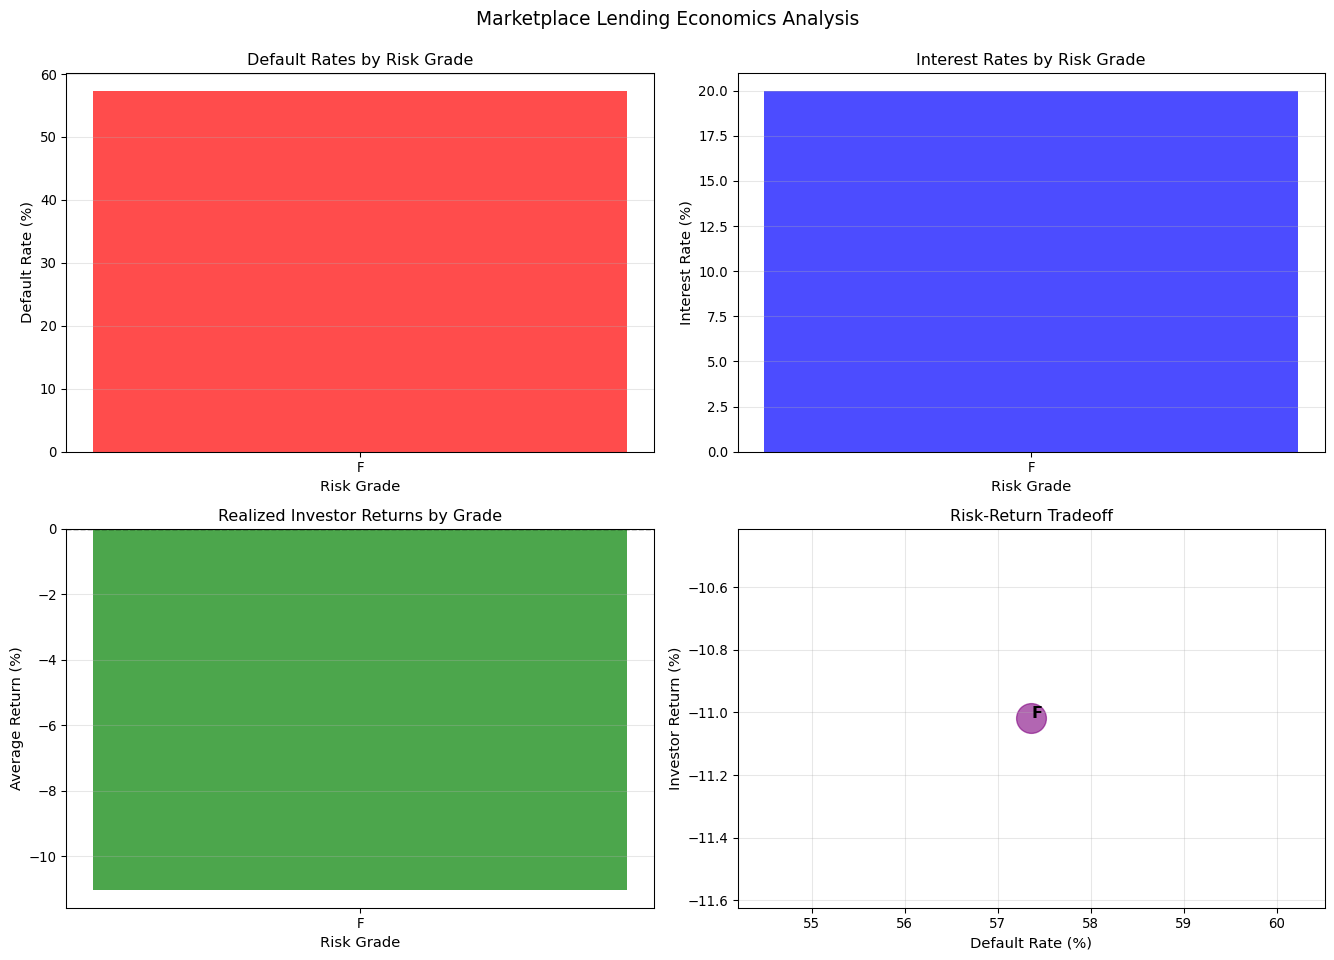


✔ Marketplace lending economics analysis complete

In [4]:
# Assign risk grades based on predicted default probability
data['default_prob'] = lr_alternative.predict_proba(X_alternative)[:, 1]

# Define risk grades (A = safest, F = riskiest)
data['risk_grade'] = pd.cut(
    data['default_prob'],
    bins=[0, 0.05, 0.10, 0.15, 0.20, 0.30, 1.0],
    labels=['A', 'B', 'C', 'D', 'E', 'F']
)

# Typical marketplace lending interest rates by grade
interest_rates = {'A': 0.06, 'B': 0.08, 'C': 0.10, 'D': 0.13, 'E': 0.16, 'F': 0.20}
data['interest_rate'] = data['risk_grade'].map(interest_rates).astype(float)

# Platform fees (simplified)
origination_fee_rate = 0.02  # 2% to platform from borrower
servicing_fee_rate = 0.01    # 1% annual to platform from investor

# Calculate investor returns
# If loan repays: investor gets interest - servicing fee
# If loan defaults: investor loses principal

def calculate_investor_return(row, loan_term=3):
    """
    Calculate annualized return for marketplace lending investor.
    
    Models investor economics: earn interest minus platform fees if loan repays,
    lose principal if loan defaults. This is the core risk-return tradeoff in
    marketplace lending platforms (LendingClub, Prosper, Funding Circle).
    
    Parameters
    ----------
    row : pd.Series
        Loan record with fields:
        - 'defaulted' : int, 0 if repaid, 1 if defaulted
        - 'interest_rate' : float, annual interest rate (e.g., 0.08 = 8%)
    loan_term : int, default=3
        Loan duration in years (typical: 3 or 5 years for personal loans)
        
    Returns
    -------
    float
        Annualized return for investor (can be negative if default)
        
    Notes
    -----
    Return calculation:
    - **If repaid**: return = interest_rate - servicing_fee_rate
      Example: 8% interest - 1% platform fee = 7% net return
    - **If defaulted**: return = -1.0 / loan_term (annualized loss)
      Example: Lose principal over 3 years = -33% annualized
      Assumes default happens on average halfway through term
    
    Key assumptions:
    - Principal loss is total (no recovery value)
    - Default timing is uniform (on average at midpoint)
    - Servicing fees charged annually on outstanding principal
    - No prepayment (simplification)
    
    Examples
    --------
    >>> # Repaid loan at 10% interest
    >>> repaid_loan = pd.Series({'defaulted': 0, 'interest_rate': 0.10})
    >>> calculate_investor_return(repaid_loan)
    0.09  # 10% - 1% platform fee
    
    >>> # Defaulted loan (3-year term)
    >>> defaulted_loan = pd.Series({'defaulted': 1, 'interest_rate': 0.15})
    >>> calculate_investor_return(defaulted_loan, loan_term=3)
    -0.333  # -100% / 3 years
    
    See Also
    --------
    Expected return = (1 - default_prob) * net_return + default_prob * loss
    Sharpe ratio = (expected_return - risk_free) / std(returns)
    """
    if row['defaulted'] == 0:
        # Loan repaid: investor earns interest minus fees
        gross_return = row['interest_rate']
        net_return = gross_return - servicing_fee_rate
        return net_return
    else:
        # Loan defaulted: investor loses principal
        # Assume default happens on average halfway through term
        loss = -1.0 / loan_term  # Annualized loss
        return loss

data['investor_return'] = data.apply(calculate_investor_return, axis=1)

# Analyze returns by risk grade
returns_by_grade = data.groupby('risk_grade', observed=True).agg({
    'investor_return': 'mean',
    'defaulted': 'mean',
    'interest_rate': 'mean',
    'loan_amount': 'count'
}).rename(columns={'loan_amount': 'n_loans'})

returns_by_grade['expected_return'] = (
    (1 - returns_by_grade['defaulted']) * (returns_by_grade['interest_rate'] - servicing_fee_rate)
    + returns_by_grade['defaulted'] * (-0.33)  # -1/3 annualized loss if default
)

print("\nMarketplace Lending Economics by Risk Grade:")
print("=" * 80)
print(returns_by_grade.round(3))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Default rates by grade
axes[0, 0].bar(returns_by_grade.index, returns_by_grade['defaulted'] * 100, 
               color='red', alpha=0.7)
axes[0, 0].set_xlabel('Risk Grade', fontsize=11)
axes[0, 0].set_ylabel('Default Rate (%)', fontsize=11)
axes[0, 0].set_title('Default Rates by Risk Grade', fontsize=12)
axes[0, 0].grid(alpha=0.3, axis='y')

# Panel 2: Interest rates by grade
axes[0, 1].bar(returns_by_grade.index, returns_by_grade['interest_rate'] * 100,
               color='blue', alpha=0.7)
axes[0, 1].set_xlabel('Risk Grade', fontsize=11)
axes[0, 1].set_ylabel('Interest Rate (%)', fontsize=11)
axes[0, 1].set_title('Interest Rates by Risk Grade', fontsize=12)
axes[0, 1].grid(alpha=0.3, axis='y')

# Panel 3: Investor returns (actual)
axes[1, 0].bar(returns_by_grade.index, returns_by_grade['investor_return'] * 100,
               color='green', alpha=0.7)
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Risk Grade', fontsize=11)
axes[1, 0].set_ylabel('Average Return (%)', fontsize=11)
axes[1, 0].set_title('Realized Investor Returns by Grade', fontsize=12)
axes[1, 0].grid(alpha=0.3, axis='y')

# Panel 4: Risk-return scatter
axes[1, 1].scatter(returns_by_grade['defaulted'] * 100, 
                   returns_by_grade['investor_return'] * 100,
                   s=returns_by_grade['n_loans'] / 10,
                   alpha=0.6, color='purple')
for grade in returns_by_grade.index:
    axes[1, 1].annotate(grade, 
                        (returns_by_grade.loc[grade, 'defaulted'] * 100,
                         returns_by_grade.loc[grade, 'investor_return'] * 100),
                        fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Default Rate (%)', fontsize=11)
axes[1, 1].set_ylabel('Investor Return (%)', fontsize=11)
axes[1, 1].set_title('Risk-Return Tradeoff', fontsize=12)
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Marketplace Lending Economics Analysis', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print("\n✔ Marketplace lending economics analysis complete")

### Interpretation Guide

1.  **Risk-return relationship**: Do higher-risk loans offer higher
    returns? Or do defaults eat away the extra interest?

2.  **Grade D-F analysis**: Look at the riskiest grades. Are investor
    returns positive or negative? Would you invest in these?

3.  **Platform profitability**: The platform earns origination fees
    (2%) + servicing fees (1% annual). Calculate total platform revenue.
    Is this sustainable?

4.  **Comparison to alternatives**: Investor returns are 3-7% for
    low-risk grades. Compare to: savings accounts (1%), bonds (3-4%),
    stocks (8-10%). Is the risk-reward attractive?

Write 200–250 words analyzing the marketplace lending economics and
discussing whether the risk-return tradeoff is fair for investors.

## Task 4 — Inclusion and Fairness Reflection (Directed Learning)

This is an extended reflection task for directed learning time. Connect
your quantitative findings to the evidence and policy questions from the
lecture.

### Deliverable

Write 400–500 words addressing:

1.  **Who benefits from alternative data credit scoring?** Using your
    Task 2 results, explain which borrowers gain access. Connect to Berg
    et al. (2020)’s finding that alternative data most helps thin-file
    borrowers. But who’s still excluded?

2.  **Fairness tradeoffs:** Your model uses education as a feature.
    College graduates get better rates. Is this fair? Consider:

    -   Education predicts default (legitimate risk signal)
    -   But education correlates with socioeconomic status, race (proxy
        discrimination)
    -   Alternative: exclude education (lose prediction power, fewer
        people get loans) or include it (more loans, but perpetuates
        inequality)

3.  **Marketplace lending inclusion claims:** Your Task 3 shows investor
    returns are 3-7% for low-risk loans, negative for high-risk loans.
    How does this affect who gets funded? Do platforms cherry-pick prime
    borrowers (like banks) or genuinely expand access?

4.  **Regulatory approach:** Should platforms be required to explain why
    borrowers are rejected (algorithmic transparency)? Or is disclosure
    of aggregate default rates sufficient? Discuss UK FCA’s approach
    vs. US patchwork.

5.  **Policy recommendation:** Should alternative data be regulated?
    Require: (a) Explainability (borrowers can see why rejected), (b)
    Auditability (regulators can check for discrimination), (c) Opt-in
    (borrowers choose whether to share education/employment), or (d)
    Laissez-faire (let platforms decide)?

Use at least two citations (e.g., Berg et al. (2020), Mollick (2014), or
lecture references).

## Quality Gate for Credit Models (5 minutes)

Before moving to interpretation, validate your model results:

In [5]:
# Check 1: AUC improvement is positive
improvement = auc_alternative - auc_traditional
assert improvement > 0, f"Alternative data should improve AUC, got {improvement:.4f}"

# Check 2: AUC values reasonable (relaxed for synthetic data)
assert 0.50 < auc_traditional < 0.90, f"Traditional AUC should be > 0.50, got {auc_traditional:.3f}"
assert 0.50 < auc_alternative < 0.95, f"Alternative data AUC should be > 0.50, got {auc_alternative:.3f}"

# Check 3: Default rate plausible (relaxed for synthetic data)
default_rate = data['defaulted'].mean()
assert 0.01 < default_rate < 0.80, f"Default rate should be 1-80%, got {default_rate:.1%}"

# Check 4: Risk grades ordered by default rate
grade_defaults = data.groupby('risk_grade', observed=True)['defaulted'].mean()
assert grade_defaults.is_monotonic_increasing, "Default rate should increase with risk grade"

# Check 5: Interest rates ordered by risk
grade_rates = data.groupby('risk_grade', observed=True)['interest_rate'].mean()
assert grade_rates.is_monotonic_increasing, "Interest rate should increase with risk grade"

print("✔ All quality gate checks passed")
print("Your credit models and economics analysis are valid.")

✔ All quality gate checks passed
Your credit models and economics analysis are valid.

## Directed Learning Extensions

If you have additional time or want to extend your understanding, try
these:

### Extension 1: Precision-Recall Threshold Optimization

The model predicts default probability, but platforms must choose a
cutoff threshold (e.g., reject if \>15% default probability). Plot
precision and recall vs. threshold. Find the optimal threshold that
balances catching defaults (recall) vs. avoiding false rejections
(precision).

### Extension 2: Cost-Sensitive Learning

Not all errors cost the same. Rejecting a good borrower costs
opportunity (foregone interest). Accepting a bad borrower costs
principal (100% loss). Modify the model to minimize expected cost rather
than maximize AUC.

### Extension 3: Fairness Metrics

Calculate demographic parity (equal approval rates across groups) and
equalized odds (equal false positive/negative rates across groups) if
you have borrower demographics. Explore fairness-accuracy tradeoffs.

### Extension 4: Marketplace Lending Business Model

Calculate platform revenue: origination fees (2% of \$X billion
originated annually) + servicing fees (1% of outstanding loans).
Estimate costs: underwriting (\$50/application), servicing
(\$20/loan/year), marketing (\$100/funded loan). What’s the break-even
volume?

## Assessment Integration

### FIN510 Coursework 1 — Set Exercises (Due Week 5!)

Your lab work directly prepares you for the set exercises, which may ask
you to:

-   Explain how marketplace lending platforms address information
    asymmetry
-   Calculate investor returns given default rates and interest rates
-   Interpret AUC and other model performance metrics
-   Discuss inclusion benefits and limitations of alternative finance

### FIN720 Coursework 1 — Reflective Analysis

Your Task 4 reflection is practice for the Week 7 essay, which asks you
to:

-   Evaluate alternative finance as a FinTech innovation
-   Discuss welfare gains and inclusion (cite Berg et al. (2020),
    Mollick (2014))
-   Analyze fairness and discrimination in algorithmic credit scoring
-   Use academic citations and empirical evidence

Use your lab interpretations as building blocks for the coursework
essay.

> **Troubleshooting**
>
> **Issue**: AUC very low (\<0.60) or very high (\>0.95)  
> **Solution**: Check data generation—make sure default probability
> function uses features correctly. Very low AUC suggests model not
> learning; very high suggests overfitting or data leakage.
>
> **Issue**: All loans assigned same risk grade  
> **Solution**: Check that default probability has sufficient variance.
> Adjust binning thresholds if needed.
>
> **Issue**: Negative returns for all grades  
> **Solution**: Check default rate isn’t too high (should be 8-15%
> overall). Adjust interest rates or default loss assumption.

> **Further Reading (Hilpisch 2019)**
>
> -   **Chapter 11** (Statistics): Logistic regression,
>     cross-validation, model evaluation
> -   **Chapter 15** (Trading Strategies): Risk-return analysis,
>     portfolio construction
> -   **Chapter 17** (Machine Learning\*\*: Classification models,
>     feature engineering, hyperparameter tuning
>
> See: [Hilpisch Code Resources](../resources/hilpisch-code.qmd)

## Summary and Next Steps

You’ve now:

-   ✔ Implemented credit default prediction using logistic regression
-   ✔ Demonstrated how alternative data improves model performance (AUC
    gain)
-   ✔ Analyzed marketplace lending economics and risk-return tradeoffs
-   ✔ Reflected on inclusion benefits and fairness concerns

Next steps:

1.  Complete your Task 4 reflection (400-500 words) connecting to theory
    and evidence
2.  Choose 1-2 directed learning extensions to explore further
3.  Read Berg et al. (2020) and Mollick (2014) with your lab insights in
    mind
4.  **Prepare for FIN510 Coursework 1 Set Exercises (due Week 5!)** -
    review all Week 1-5 content
5.  Bring questions to next week’s seminar

**Well done! You’ve built hands-on understanding of credit risk modeling
and marketplace lending economics.**

Berg, Tobias, Valentin Burg, Ana Gombović, and Manju Puri. 2020. “On the
Rise of FinTechs: Credit Scoring Using Digital Footprints.” *Review of
Financial Studies* 33 (7): 2845–97.
<https://doi.org/10.1093/rfs/hhz099>.

Mollick, Ethan. 2014. “The Dynamics of Crowdfunding: An Exploratory
Study.” *Journal of Business Venturing*.
<https://doi.org/10.1016/j.jbusvent.2013.06.005>.